In [1]:
!conda info



     active environment : None
       user config file : /home/jovyan/.condarc
 populated config files : /opt/conda/.condarc
          conda version : 23.9.0
    conda-build version : not installed
         python version : 3.11.6.final.0
       virtual packages : __archspec=1=x86_64
                          __glibc=2.35=0
                          __linux=6.14.0=0
                          __unix=0=0
       base environment : /opt/conda  (writable)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
          package cache : /opt/conda/pkgs
                          /home/jovyan/.conda/pkgs
       envs directories : /opt/conda/envs
                          /home/jovyan/.conda/envs
               platform : linux-64
             user-agent : conda/23.9.0 requests/2.31.0 CPython/3.11.6 Linux/6.14.0-29-generic ubunt

In [2]:
!conda install -y -c conda-forge graphviz




Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x77bb4f3a9a50>: Failed to resolve 'conda.anaconda.org' ([Errno -3] Temporary failure in name resolution)")': /conda-forge/noarch/current_repodata.json

/ Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x77bb4f3aa090>: Failed to resolve 'conda.anaconda.org' ([Errno -3] Temporary failure in name resolution)")': /conda-forge/linux-64/current_repodata.json

Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x77bb4f3aa790>: Failed to resolve 'conda.anaconda.org' ([Errno -3] Temporary failure in name resolution)")': /conda-forge/noarch/current_repodata.json

| Retrying (Re

# Exercício de Árvore de Decisão: Classificação de Vinhos

**Objetivo:** Neste exercício, você irá treinar, visualizar e avaliar um classificador de Árvore de Decisão usando o dataset 'wine' do Scikit-Learn. Você focará nos conceitos introduzidos no Capítulo 6, até a seção "Gini Impurity or Entropy?", incluindo a divisão treino/teste, treinamento, visualização da árvore, plotagem dos limites de decisão e avaliação de desempenho usando validação cruzada e métricas de classificação.

## 1. Configuração e Importações

Primeiro, vamos importar as bibliotecas necessárias.

**Obs.: a instalação do pacote graphviz pode levar mais de 10 minutos!**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Para plotar figuras bonitas
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Onde salvar as figuras
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Função auxiliar para plotar limites de decisão
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = mpl.colors.ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = mpl.colors.ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Classe 0")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Classe 1")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Classe 2")
        plt.axis(axes)
    if iris:
        plt.xlabel("Comprimento da pétala (cm)", fontsize=14)
        plt.ylabel("Largura da pétala (cm)", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

## 2. Carregar e Preparar os Dados

Vamos carregar o dataset `wine` e usar apenas duas características para facilitar a visualização: 'alcohol' e 'malic_acid'.

In [4]:
wine = load_wine(as_frame=True)
print(wine.DESCR)
wine.data.info()
wine.data.head()

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
# Selecionar apenas as features 'alcohol' e 'malic_acid'
X = wine.data[["alcohol", "malic_acid"]].values
y = wine.target.values

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Shape de X: (178, 2)
Shape de y: (178,)


## 3. Dividir os Dados em Conjuntos de Treino e Teste

**Sua tarefa:** Use `train_test_split` para dividir os dados `X` e `y` em conjuntos de treinamento e teste. Use 20% dos dados para teste e defina `random_state=42` para reprodutibilidade.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = None, None, None, None

# <<< SEU CÓDIGO AQUI >>>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# <<< FIM DO SEU CÓDIGO >>>

print("Tamanho do treino:", len(X_train))
print("Tamanho do teste:", len(X_test))

Tamanho do treino: 142
Tamanho do teste: 36


## 4. Treinar um Classificador de Árvore de Decisão

**Sua tarefa:** Treine um `DecisionTreeClassifier` com `max_depth=2` e `random_state=42` no conjunto de treinamento.

In [7]:
tree_clf_depth2 = None

# <<< SEU CÓDIGO AQUI >>>
tree_clf_depth2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_depth2.fit(X_train, y_train)
...
# <<< FIM DO SEU CÓDIGO >>>

print("Modelo treinado com max_depth=2.")

Modelo treinado com max_depth=2.


## 5. Visualizar a Árvore de Decisão

Usamos `export_graphviz` para gerar um arquivo `.dot` representando a árvore treinada. Incluímos os nomes das características ('alcohol', 'malic_acid') e os nomes das classes (do dataset `wine`). Em seguida, exibimos a árvore usando `graphviz.Source`.

In [12]:
from sklearn.tree import export_graphviz
from graphviz import Source

dot_file_path = IMAGES_PATH / "wine_tree_depth2.dot"

export_graphviz(
    tree_clf_depth2,
    out_file=str(dot_file_path),
    feature_names=["alcohol", "malic_acid"],
    class_names=wine.target_names,
    rounded=True,
    filled=True
)

# Exibir a árvore
source = Source.from_file(dot_file_path)
source

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## 6. Plotar os Limites de Decisão

Usamos a função auxiliar `plot_decision_boundary` para visualizar os limites de decisão da árvore treinada (`tree_clf_depth2`) no conjunto de treinamento (`X_train`, `y_train`). Ajustamos os eixos para uma boa visualização.

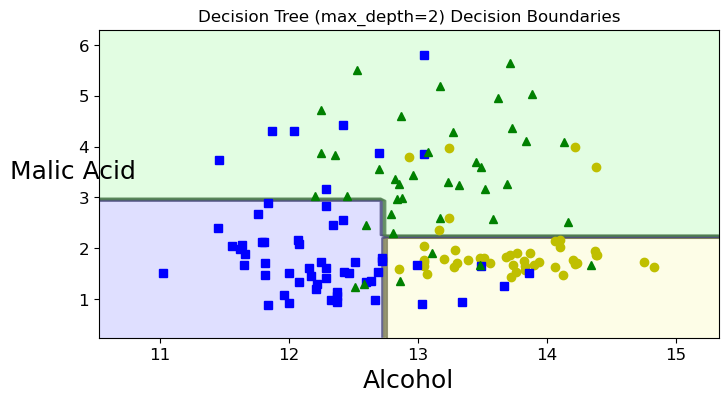

In [9]:
plt.figure(figsize=(8, 4))

axes = [X[:, 0].min()-0.5, X[:, 0].max()+0.5, X[:, 1].min()-0.5, X[:, 1].max()+0.5]
plot_decision_boundary(tree_clf_depth2, X_train, y_train, axes=axes, iris=False)
plt.xlabel("Alcohol")
plt.ylabel("Malic Acid")
plt.title("Decision Tree (max_depth=2) Decision Boundaries")

plt.show()

## 7. Comparar Profundidades Usando Validação Cruzada

**Sua tarefa:** Use validação cruzada (com `cross_val_score`, `cv=5` e `scoring='accuracy'`) no conjunto de **treinamento** para comparar o desempenho médio de árvores com `max_depth=2` e `max_depth=3`. Qual profundidade parece ser melhor?

In [13]:
tree_clf_depth3 = None
scores_depth2 = None
scores_depth3 = None

# <<< SEU CÓDIGO AQUI >>>
# Crie o classificador com max_depth=3
tree_clf_depth3 = DecisionTreeClassifier(max_depth=3, random_state=42)

# Calcule os scores de validação cruzada para max_depth=2
# o modelo é treinado e testado 5 vezes em diferentes partes dos dados,
scores_depth2 = cross_val_score(tree_clf_depth2, X_train, y_train, cv=5, scoring="accuracy")

# Calcule os scores de validação cruzada para max_depth=3
scores_depth3 = cross_val_score(tree_clf_depth3, X_train, y_train, cv=5, scoring="accuracy")
# <<< FIM DO SEU CÓDIGO >>>

print(f"Acurácia média (max_depth=2): {np.mean(scores_depth2):.4f}")
print(f"Acurácia média (max_depth=3): {np.mean(scores_depth3):.4f}")

# <<< SEU CÓDIGO AQUI para imprimir qual profundidade é melhor e por quê >>>
# A função np.mean(scores_depth3) serve para calcular a média dos valores que 
# estão dentro da variável scores_depth3.
if np.mean(scores_depth3) > np.mean(scores_depth2):
    print("\n➡️ A profundidade 3 é melhor, pois obteve maior acurácia média.")
    print("Isso indica que o modelo conseguiu capturar mais padrões dos dados sem perder muita generalização.")
elif np.mean(scores_depth3) < np.mean(scores_depth2):
    print("\n➡️ A profundidade 2 é melhor, pois apresentou melhor desempenho médio.")
    print("Isso sugere que o modelo com profundidade 3 começou a se ajustar demais aos dados de treino (overfitting).")
else:
    print("\n➡️ Ambas as profundidades têm o mesmo desempenho médio.")
    print("Nesse caso, é preferível escolher a profundidade menor para manter o modelo mais simples e evitar overfitting.")
...
# <<< FIM DO SEU CÓDIGO >>>

Acurácia média (max_depth=2): 0.7468
Acurácia média (max_depth=3): 0.7746

➡️ A profundidade 3 é melhor, pois obteve maior acurácia média.
Isso indica que o modelo conseguiu capturar mais padrões dos dados sem perder muita generalização.


Ellipsis

## 8. Avaliar o Melhor Modelo no Conjunto de Teste

**Sua tarefa:** 
1. Selecione o melhor modelo com base nos resultados da validação cruzada.
2. **Retreine** o melhor modelo usando **todo** o conjunto de treinamento (`X_train`, `y_train`).
3. Faça previsões no conjunto de teste (`X_test`).
4. Calcule e imprima a acurácia, precisão, recall e F1-score no conjunto de teste. Use `average='weighted'` para as métricas multiclasse.

In [15]:
best_tree_clf = None
y_pred_test = None
accuracy = None
precision = None
recall = None
f1 = None

# <<< SEU CÓDIGO AQUI >>>
# 1 & 2: Selecionar e retreinar o melhor modelo (max_depth=3)
best_tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
best_tree_clf.fit(X_train, y_train)

# 3: Fazer previsões no conjunto de teste
y_pred_test = best_tree_clf.predict(X_test)

# 4: Calcular métricas
# A função cross_val_predict do scikit-learn faz validação cruzada, mas ao invés de retornar scores 
# (como cross_val_score),
# ela retorna as previsões feitas em cada rodada da validação cruzada.
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
# <<< FIM DO SEU CÓDIGO >>>

print(f"Métricas do melhor modelo (max_depth=3) no conjunto de teste:")
print(f"  Acurácia: {accuracy:.4f}")
print(f"  Precisão: {precision:.4f}")
print(f"  Recall:   {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

Métricas do melhor modelo (max_depth=3) no conjunto de teste:
  Acurácia: 0.8889
  Precisão: 0.9116
  Recall:   0.8889
  F1-Score: 0.8905


## Conclusão

Você treinou com sucesso um classificador de Árvore de Decisão, visualizou sua estrutura e limites de decisão, usou validação cruzada para escolher a melhor profundidade e avaliou o modelo final no conjunto de teste.